# term_project_report_17011266_이수

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("train.csv")
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

데이터의 feature의 개수는 총 9개로, 데이터에 있는 'PassengerID', 'Survived'는 각각 Index, 결과값이다.<br> 'Age', 'Cabin', 'Embarked' 는
데이터의 소실이 있음을 확인할 수 있다. 

## 1. 기초 데이터 분석
데이터셋의 정제없이 각 데이터를 다음과 같이 시각화한다.

<Axes: xlabel='Embarked', ylabel='Survived'>

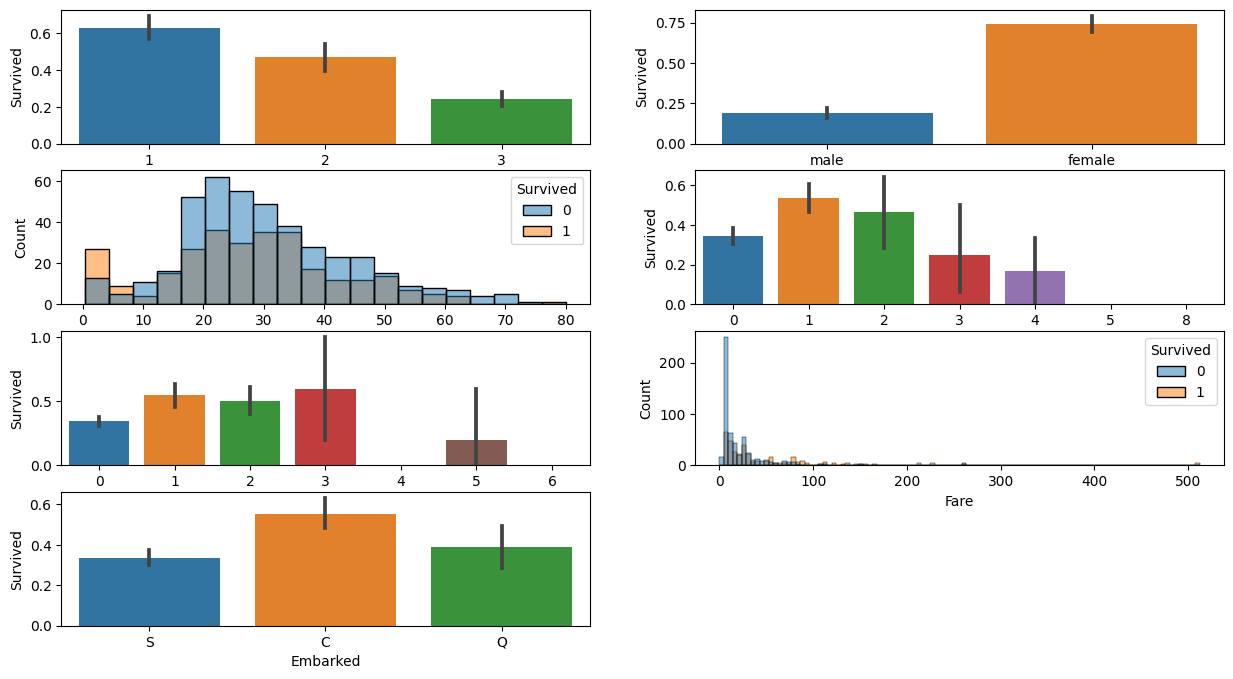

In [2]:
# 1) Pclass : Categorical
plt.figure(figsize=(15,8))
plt.subplot(4,2,1)
sns.barplot(x='Pclass',y='Survived', data=df)
# 2) Sex : Categorical
plt.subplot(4,2,2)
sns.barplot(x='Sex', y='Survived', data=df)
# 3) Age : Numerical
plt.subplot(4,2,3)
sns.histplot(x='Age', hue='Survived', data=df)
# 4) SibSp : Categorical
plt.subplot(4,2,4)
sns.barplot(x='SibSp', y='Survived', data=df)
# 5) Parch : Categorical
plt.subplot(4,2,5)
sns.barplot(x='Parch', y='Survived', data=df)
# 6) Fare : Numerical
plt.subplot(4,2,6)
sns.histplot(x='Fare', hue='Survived', data=df)
# 7) Fare : Numerical
plt.subplot(4,2,7)
sns.barplot(x='Embarked', y='Survived', data=df)

## 2. 데이터 전처리 



### 'Name'
사람의 이름 중 칭호를 사용하여 사람을 구분할 수 있다. 'Name'에서 칭호를 추출하면 다음과 같다.

In [3]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

사람의 칭호를 크게 'Mr', 'Miss', 'Mrs', 'Master'로 구분할 수 있다.(Mlle와 Ms 는 Miss의, Mme는 Mrs의 불어식 표현이다.)<br>
데이터를 범주화하면 다음과 같다.

In [4]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Title'].value_counts()

Mr        518
Miss      182
Mrs       130
Master     40
Else       21
Name: Title, dtype: int64

### 'SibSp', 'Parch'
'SibSp','Parch' 데이터 모두 가족 구성원과 관련된 데이터이다. 데이터 간소화를 위해 두 데이터를 합하여 새로운 데이터 'Family'를 생성한다.<br>
'Family'는 자신을 제외한 나머지 가족 구성원을 수를 확인할 수 있는 데이터가 된다.

In [5]:
df['Family'] = df['SibSp']+df['Parch']
df['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

'Family' 데이터의 범주화를 위해 데이터값이 4 이상인 경우 전부 4로 통일한다.

In [6]:
df.loc[(df['Family'] > 3),'Family'] = 4
df['Family'].value_counts().sort_index()

0    537
1    161
2    102
3     29
4     62
Name: Family, dtype: int64

### 'Age'
 'Age' 데이터의 일부는 소실이 있다. 소실 데이터는 'Title', 'Sex' 데이터를 기반으로 보완한다. 사람을 부르는 칭호 중 'Master'는 어린 남자아이를 칭하는 단어다. 소실 데이터 중 해당 칭호를 갖는 탑승객의 나이는 10으로 입력한다. 그 외는 각 성별의 나이의 평균값으로 입력한다.

In [7]:
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']=='Master'),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()

### 'Cabin'
'Cabin' 데이터는 승객의 선실 위치로, 앞의 알파벳은 데크층, 뒤의 숫자는 호실이다. 해당 데이터는 소실 데이터가 많아 학습에 그대로 사용할 수 없다.  따라서 타이타닉의 구조을 기반으로 소실 데이터를 보완한다. 타이타닉의 데크 구조는 아래 그림과 같다. 1등실 승객들은 A-E데크, 2등실, 3등실 승객들은 E-G데크에 선실이 있음을 확인할 수 있다. 

<img src="Screenshot%20from%202023-05-25%2021-29-27.png" width="80%" height="80%"/>

한 편, 보유 데이터 중 선실 등급별로 'Cabin' 데이터를 확인하면 다음과 같다.

In [8]:
df['Ncabin'] = df['Cabin'].str.extract('([A-Z])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")
pd.crosstab(df['Pclass'],df['Ncabin'])

Ncabin,A,B,C,D,E,F,G,N,T
Pclass,,,,,,,,,
1,15,47,59,29,25,0,0,40,1
2,0,0,0,4,4,8,0,168,0
3,0,0,0,0,3,5,4,479,0


대부분의 1등실 승객은 선실이 존재하는 반면, 2등,3등실 승객은 선실 데이터가 소실되었음을 확인할 수 있다.
1등실의 소실 데이터는 가장 데이터가 많은 C로 지정하는 반면, 2등,3등실은 선 내 평균적인 배치를 확인하기 어렵기에 N이라는 새로운 값으로 지정한다.
1등실 승객 중 T데크 선실을 배정받은 승객이 있는데 해당 데크의 데이터가 부족한 바 N으로 값을 변경하여 학습시킨다.

In [9]:
df.loc[(df['Pclass']==1) & (df['Cabin'].isnull()),'Cabin'] = 'C'
df.loc[(df['Pclass']==2) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df.loc[(df['Pclass']==3) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")

### 'Fare', 'Pclass'
같은 등급의 선실을 사용하여도 각 인원의 승선요금은 천차만별이다. 각 등급별 요금 분포는 다음과 같다.


<Axes: xlabel='Fare', ylabel='Count'>

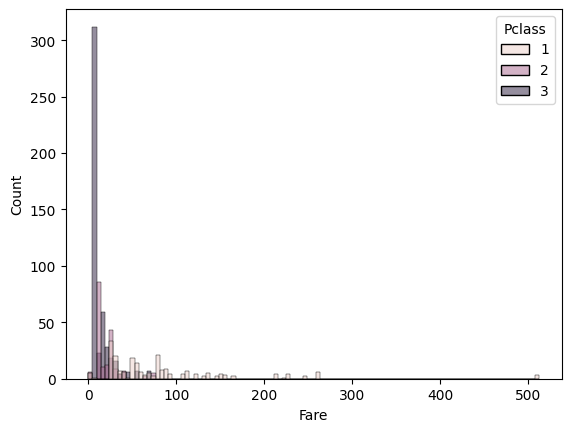

In [10]:
sns.histplot(x='Fare', hue='Pclass', data=df)

위 분포도를 통해 1등실 승객 중에서도 2,3등실 승객들과 비슷한 요금을 지불하고 탑승한 인원들이 있음을 확인할 수 있다. 이를 구분하기 위해 'Class'라는 새로운 데이터를 생성한다.
각 선실 등급별 요금의 중앙값을 기준으로 승객 등급을 세분화한다.
 

In [11]:
df.loc[(df['Pclass']==1) & (df['Fare'] > df[df['Pclass']==1]['Fare'].median()),'Class'] = 'A'
df.loc[(df['Pclass']==1) & (df['Fare'] <= df[df['Pclass']==1]['Fare'].median()),'Class'] = 'B'
df.loc[(df['Pclass']==2) & (df['Fare'] > df[df['Pclass']==2]['Fare'].median()),'Class'] = 'C'
df.loc[(df['Pclass']==2) & (df['Fare'] <= df[df['Pclass']==2]['Fare'].median()),'Class'] = 'D'
df.loc[(df['Pclass']==3) & (df['Fare'] > df[df['Pclass']==3]['Fare'].median()),'Class'] = 'E'
df.loc[(df['Pclass']==3) & (df['Fare'] <= df[df['Pclass']==3]['Fare'].median()),'Class'] = 'F'

## 3. 데이터 처리 후 분석
데이터의 전처리 후 데이터를 다음과 같이 시각화할 수 있다.

<Axes: xlabel='Age', ylabel='Count'>

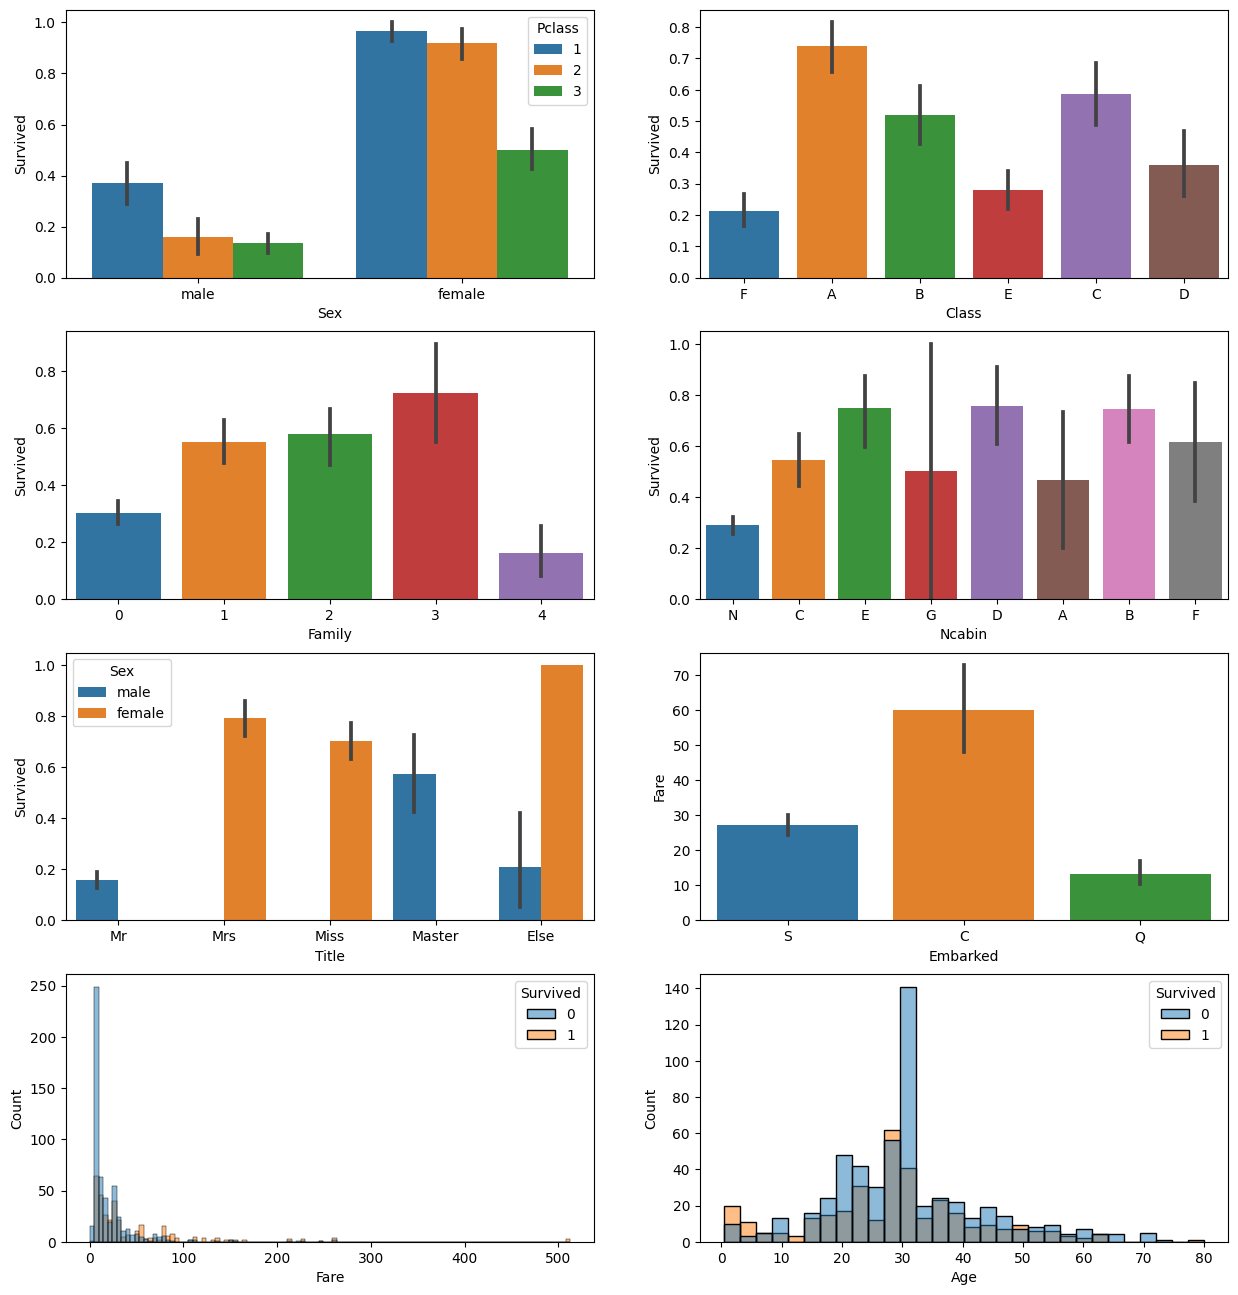

In [12]:
plt.figure(figsize=(15,16))
plt.subplot(4,2,1)
sns.barplot(x='Sex',y='Survived', hue='Pclass', data=df)
plt.subplot(4,2,2)
sns.barplot(x='Class', y='Survived', data=df)
plt.subplot(4,2,3)
sns.barplot(x='Family', y='Survived', data=df)
plt.subplot(4,2,4)
sns.barplot(x='Ncabin', y='Survived', data=df)
plt.subplot(4,2,5)
sns.barplot(x='Title', y='Survived', hue='Sex', data=df)
plt.subplot(4,2,6)
sns.barplot(x='Embarked', y='Fare', data=df)
plt.subplot(4,2,7)
sns.histplot(x='Fare', hue='Survived', data=df)
plt.subplot(4,2,8)
sns.histplot(x='Age', hue='Survived', data=df)

## 4. 데이터 학습, 모델 생성

'PassengerId'는 데이터의 인덱스이기에 학습에 필요없고, 'Name', 'Ticket', 'SibSp', 'Parch', 'Cabin'은 데이터 처리 후 새롭게 데이터를 생성하였으므로 필요 없다.<br>
한 편, 'Sex'는 칭호 데이터 'Title'에 내제되어있다고 볼 수 있고, 'Embarked'는 'Fare' 데이터와 유사하다고 판단하여 학습데이터에서 제거한다.

In [13]:
df.drop(['PassengerId','Name', 'Ticket', 'SibSp','Parch','Sex','Cabin','Embarked'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Age       891 non-null    float64
 3   Fare      891 non-null    float64
 4   Title     891 non-null    object 
 5   Family    891 non-null    int64  
 6   Ncabin    891 non-null    object 
 7   Class     891 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 55.8+ KB


결론적으로 모델에서 학습시키는 데이터는 총 7종류로, 수치형 데이터 2개, 범주형 데이터 5개이다. 수치형 데이터는 표준화, 정규화를 통해 데이터를 가공하고,<br>
범주형 데이터는 원-핫 벡터로 처리하여 데이터 학습에 사용한다.

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df[['Pclass','Title','Family','Ncabin','Class']] = df[['Pclass','Title','Family','Ncabin','Class']].astype('string')
stscaler.fit(df[['Age','Fare']])
scaled = stscaler.transform(df[['Age','Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(scaled, columns=['Age','Fare'])
df['Age'] = output['Age']
df['Fare'] = output['Fare']
df = pd.get_dummies(df,drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Age           891 non-null    float64
 2   Fare          891 non-null    float64
 3   Pclass_2      891 non-null    uint8  
 4   Pclass_3      891 non-null    uint8  
 5   Title_Master  891 non-null    uint8  
 6   Title_Miss    891 non-null    uint8  
 7   Title_Mr      891 non-null    uint8  
 8   Title_Mrs     891 non-null    uint8  
 9   Family_1      891 non-null    uint8  
 10  Family_2      891 non-null    uint8  
 11  Family_3      891 non-null    uint8  
 12  Family_4      891 non-null    uint8  
 13  Ncabin_B      891 non-null    uint8  
 14  Ncabin_C      891 non-null    uint8  
 15  Ncabin_D      891 non-null    uint8  
 16  Ncabin_E      891 non-null    uint8  
 17  Ncabin_F      891 non-null    uint8  
 18  Ncabin_G      891 non-null    

데이터 학습에 K-fold 방식으로 학습 데이터를 10개로 분할하여 각 모델 학습결과를 비교하였다. 학습 데이터가 1000개 이하인 점을 고려하여 예측의 정확도보다 각 예측률의 분포도를 중점으로 모델을 평가하였다.<br>
Batch size 16, epoch 100번으로 학습시켰으며 학습 결과, 다음 모델의 예측률 분포도가 고르게 나왔으며, 모델의 레이어 구조는 다음과 같다.

In [15]:
from keras.models import load_model
model = load_model('please.h5')
model.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_257 (Dense)           (None, 16)                400       
                                                                 
 dropout_98 (Dropout)        (None, 16)                0         
                                                                 
 dense_258 (Dense)           (None, 8)                 136       
                                                                 
 dropout_99 (Dropout)        (None, 8)                 0         
                                                                 
 dense_259 (Dense)           (None, 8)                 72        
                                                                 
 dense_260 (Dense)           (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable

모델의 첫 번째 레이어와 출력 레이어는 Sigmoid, 2,3번째 레이어는 Relu 함수를 사용하여 모델을 구성하였다. 히든 레이어 구성 간에 25%의 dropout을 구성하여 모델의 과잉적합을 방지하였다.테스트 데이터의 예측값 제출 결과, 0.78708의 정확도를 얻을 수 있었다.